### Imports

In [ ]:
# ruff: noqa
from pydantic import BaseModel, Field

from qdrant_client import QdrantClient
from qdrant_client.models import Prefetch, FusionQuery, Document


from langsmith import traceable

from langgraph.graph import StateGraph, START, END
from langgraph.types import Send


from jinja2 import Template
from typing import Annotated, List
from operator import add
from openai import OpenAI

import openai

import instructor

In [17]:
qdrant_client_ = QdrantClient(url="http://localhost:6333")

In [18]:
def get_embedding(text, model="text-embedding-3-small"):
    response = openai.embeddings.create(
        input=[text],
        model=model,
    )
    return response.data[0].embedding

In [19]:
def retrieve_data(query, qdrant_client, k=5):
    query_embedding = get_embedding(query)

    results = qdrant_client.query_points(
        collection_name="Amazon-items-collection-01-hybrid-search",
        prefetch=[
            Prefetch(query=query_embedding, using="text-embedding-3-small", limit=20),
            Prefetch(
                query=Document(text=query, model="qdrant/bm25"), using="bm25", limit=20
            ),
        ],
        query=FusionQuery(fusion="rrf"),
        limit=k,
    )

    retrieved_context_ids = []
    retrieved_context = []
    retrieved_context_ratings = []
    similarity_scores = []

    for result in results.points:
        retrieved_context_ids.append(result.payload["parent_asin"])
        retrieved_context.append(result.payload["description"])
        retrieved_context_ratings.append(result.payload["average_rating"])
        similarity_scores.append(result.score)

    return {
        "retrieved_context_ids": retrieved_context_ids,
        "retrieved_context": retrieved_context,
        "retrieved_context_ratings": retrieved_context_ratings,
        "similarity_scores": similarity_scores,
    }

In [20]:
query = "Can I get some tablet?"

In [21]:
answer = retrieve_data(query, qdrant_client=qdrant_client_, k=10)

Fetching 18 files: 100%|██████████| 18/18 [00:00<00:00, 29.49it/s]


In [22]:
answer

{'retrieved_context_ids': ['B0B8NVNQKX',
  'B09LH466KZ',
  'B0BR33XH8D',
  'B0BN7WWH63',
  'B0C78B1BTB',
  'B0BL2CZSHT',
  'B0BFGXRMJN',
  'B08CGM6Y1J',
  'B0C3XYD574',
  'B0C772GZRF'],
 'retrieved_context': ['COOPERS 7 inch Kids Tablet Android 11 Tablet for Kids, 2GB RAM + 32GB ROM Toddler Tablet PC for Children, IPS Touch Screen, Dual Camera, Dual Speaker, WiFi Computer Tablet, Light Blue ✿【Good Kids tablet】This 7 inch tablet for kids with silm body and lightweight, it is easy to hold by children. Also the special design can protect the tablet well when dropping. ✿【Parental Control】Toddlers Tablet with parent mode can add or block apps. Set screen time limits. This tablet come with iwawa app. kids can get access to fun and educational games and videos. ✿【Powerful Tablets】Equipmented with quad core CPU, Android 11.0 System, 32GB Big Storage, 1024*600 IPS Screen offer a clear view. Runs Kinds of apps and game for kids smoothly. ✿【Long Lasting】Tablet for kids built with large capacity b

### Multi Intention Question

In [23]:
query = "Can I get some tablet for my kid, a watch for me and a laptop for my wife?"

In [24]:
answer = retrieve_data(query, qdrant_client=qdrant_client_, k=10)

In [25]:
answer

{'retrieved_context_ids': ['B0BRXZDBXZ',
  'B0BL2CZSHT',
  'B0CFFGT7RM',
  'B0C3XYD574',
  'B0B8NVNQKX',
  'B0C142QS8X',
  'B0C772GZRF',
  'B0BFGXRMJN',
  'B08CGM6Y1J',
  'B0BN7WWH63'],
 'retrieved_context': ["Kids Tablet, 7 inch Tablet for Kids 3GB RAM 32GB ROM, Android 11 Toddler Tablet with WiFi, Bluetooth, GMS, Parental Control, Shockproof Case, Google Play, YouTube, Netflix 【iWawa APP with parental control】This kids tablet has passed the GMS certification and is pre-installed with the iwawa app, specially designed for children. It has password control, remote video control, one-button lock screen and Learning, art, smart games. New-upgrade kids online school, fun interaction, video playback 【Android 11.0 & 128 GB Expand】Android 11.0 operating system, 3GB RAM 32GB ROM, support WiFi, Bluetooth, GPS, etc. The HD 1024*600IPS display can offer a perfect experience, You can expand the storage to 128 GB of SD cards for storing photos, music and videos. The upgraded battery can last more 

In [26]:
class QueryExpandResponse(BaseModel):
    statements: List[str]

In [27]:
def query_expand_node(query) -> dict:
    prompt_template = """You are part of a shopping assistant that can answer questions about products in stock.

Instructions:
- You will be given a question and you need to expand it into a list statements that can be used in contextual search to retrieve relevant products.
- The statements should not overlap in context.

<Question>
{{ query }}
</Question>
"""

    template = Template(prompt_template)

    prompt = template.render(query=query)

    client = instructor.from_openai(OpenAI())

    response, raw_response = client.chat.completions.create_with_completion(
        model="gpt-4.1-mini",
        response_model=QueryExpandResponse,
        messages=[{"role": "system", "content": prompt}],
        temperature=0.5,
    )

    return {"queries": response.statements}

In [28]:
answer = query_expand_node(query)

In [29]:
answer

{'queries': ['tablet suitable for kids',
  'watch for adults',
  'laptop for wife']}

# Langgraph

## Query Expansion

In [45]:
class State(BaseModel):
    expanded_query: List[str] = []
    retrieved_context: Annotated[List[str], add] = []
    initial_query: str = ""
    answer: str = ""

In [46]:
class QueryExpandResponse(BaseModel):
    expanded_query: List[str]

In [47]:
@traceable(
    name="agent_node",
    run_type="llm",
    metadata={"ls_provider": "openai", "ls_model_name": "gpt-4.1-mini"},
)
def query_expand_node(query) -> dict:
    prompt_template = """You are part of a shopping assistant that can answer questions about products in stock.

Instructions:
- You will be given a question and you need to expand it into a list statements that can be used in contextual search to retrieve relevant products.
- The statements should not overlap in context.

<Question>
{{ query }}
</Question>
"""

    template = Template(prompt_template)

    prompt = template.render(query=query)

    client = instructor.from_openai(OpenAI())

    response, raw_response = client.chat.completions.create_with_completion(
        model="gpt-4.1-mini",
        response_model=QueryExpandResponse,
        messages=[{"role": "system", "content": prompt}],
        temperature=0.5,
    )

    return {"expanded_query": response.expanded_query}

### Retriever

In [54]:
@traceable(
    name="embed_query",
    run_type="embedding",
    metadata={"ls_provider": "openai", "ls_model_name": "text-embedding-3-small"},
)
def get_embedding(text, model="text-embedding-3-small"):
    response = openai.embeddings.create(
        input=[text],
        model=model,
    )

    return response.data[0].embedding


@traceable(name="retrieve_top_n", run_type="retriever")
def retrieve(query, k=10) -> dict:
    qdrant_client = QdrantClient(url="http://localhost:6333")

    query_embedding = get_embedding(query)

    results = qdrant_client.query_points(
        collection_name="Amazon-items-collection-01-hybrid-search",
        prefetch=[
            Prefetch(query=query_embedding, using="text-embedding-3-small", limit=20),
            Prefetch(
                query=Document(text=query, model="qdrant/bm25"), using="bm25", limit=20
            ),
        ],
        query=FusionQuery(fusion="rrf"),
        limit=k,
    )

    retrieved_context = []
    retrieved_context_ids = []
    retrieved_context_ratings = []

    for result in results.points:
        retrieved_context_ids.append(result.payload["parent_asin"])
        retrieved_context.append(result.payload["description"])
        retrieved_context_ratings.append(result.payload["average_rating"])

    formatted_context = ""

    for id, chunk, rating in zip(
        retrieved_context_ids, retrieved_context, retrieved_context_ratings
    ):
        formatted_context += f"- ID: {id}, rating: {rating}, description: {chunk}\n"

    return formatted_context


@traceable(name="retriever_node", run_type="retriever")
def retrieve_node(state: State) -> dict:
    retrieved_context = []

    for query in state.expanded_query:
        retrieved_context.append(retrieve(query))

    return {"retrieved_context": retrieved_context}

### Aggregator Node

In [49]:
class AggregatorResponse(BaseModel):
    answer: str = Field("answer to the question")

In [50]:
@traceable(
    name="agent_node",
    run_type="llm",
    metadata={"ls_provider": "openai", "ls_model_name": "gpt-4.1-mini"},
)
def aggregator_node(state: State) -> dict:
    preprocessed_context = "\n".join(state.retrieved_context)

    prompt_template = """You are a shopping assistant that can answer questions about the products in stock.

You will be given a question and a list of context.

Instructions:
- You need to answer the question based on the provided context only.
- Never use word context and refer to it as the available products.
- The answer to the question should contain detailed information about the product and returned with detailed specification in bullet points.

Context:
{{ preprocessed_context }}

Question:
{{ question }}
"""

    template = Template(prompt_template)

    prompt = template.render(
        preprocessed_context=preprocessed_context, question=state.initial_query
    )

    client = instructor.from_openai(OpenAI())

    response, raw_response = client.chat.completions.create_with_completion(
        model="gpt-4.1-mini",
        response_model=AggregatorResponse,
        messages=[{"role": "system", "content": prompt}],
        temperature=0.5,
    )

    return {"answer": response.answer}

In [55]:
workflow = StateGraph(State)

workflow.add_node("query_expand_node", query_expand_node)
workflow.add_node("retrieve_node", retrieve_node)
workflow.add_node("aggregator_node", aggregator_node)

workflow.add_edge(START, "query_expand_node")
workflow.add_edge("query_expand_node", "retrieve_node")
workflow.add_edge("retrieve_node", "aggregator_node")
workflow.add_edge("aggregator_node", END)

graph = workflow.compile()

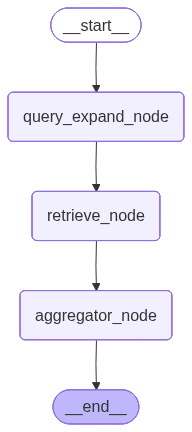

In [52]:
graph

In [56]:
initial_state = {
    "initial_query": "Can I get a tablet for my kid, a watch for me and a laptop for my wife?"
}
result = graph.invoke(initial_state)

In [58]:
print(result["answer"])

Yes, you can get a tablet for your kid, a watch for yourself, and a laptop for your wife from the available products. Here are some detailed options for each:

Tablet for Kids:
- ROWT Tablet for Kids 10 inch
  - 10.1-inch HD 1280x800 IPS touchscreen
  - Android 11 OS
  - 2GB RAM, 32GB ROM storage
  - 6000mAh battery
  - Kid-proof case with built-in stand
  - Parental controls including password protection and content filter
  - Dual cameras
  - Full access to Google Play

Watch for You:
- Smart Watch, Touch Screen Smartwatch for Android Phones
  - 1.69" full touch color screen, 240 x 280 resolution
  - 25 sports modes
  - Heart rate and sleep monitor
  - Waterproof (IP68)
  - Bluetooth calling and notifications
  - Compatible with iOS and Android

- Smart Watch for Men Women (Make/Answer Call)
  - 1.3-inch full-circle touch screen, 240x240 resolution
  - Heart rate, blood pressure, blood oxygen monitoring
  - 8 sports modes
  - Bluetooth call and message notifications
  - Stainless ste

## Query Expansion Parallel Execution

In [59]:
class State(BaseModel):
    expanded_query: List[str] = []
    retrieved_context: Annotated[List[str], add] = []
    initial_query: str = ""
    answer: str = ""
    query: str = ""
    k: int = 10

### Query Expansion Rewriting

In [60]:
class QueryExpandResponse(BaseModel):
    expanded_query: List[str]

In [61]:
@traceable(
    name="agent_node",
    run_type="llm",
    metadata={"ls_provider": "openai", "ls_model_name": "gpt-4.1-mini"},
)
def query_expand_node(state: State):
    prompt_template = """You are part of a shopping assistant that can answer questions about products in stock.

Instructions:
- You will be given a question and you need to expand it into a list statements that can be used in contextual search to retrieve relevant products.
- The statements should not overlap in context. Single item should not be expanded into multiple statements unless it is specifically mentioned in several contexts.

<Question>
{{ query }}
</Question>
"""

    template = Template(prompt_template)

    prompt = template.render(query=state.initial_query)

    client = instructor.from_openai(OpenAI())

    response, raw_response = client.chat.completions.create_with_completion(
        model="gpt-4.1-mini",
        response_model=QueryExpandResponse,
        messages=[{"role": "system", "content": prompt}],
        temperature=0.5,
    )

    return {"expanded_query": response.expanded_query}

In [62]:
def query_expand_conditional_edges(state: State):
    send_messages = []

    for query in state.expanded_query:
        send_messages.append(Send("retrieve_node", {"query": query, "k": 10}))

    return send_messages

### Retriever

In [63]:
@traceable(
    name="embed_query",
    run_type="embedding",
    metadata={"ls_provider": "openai", "ls_model_name": "text-embedding-3-small"},
)
def get_embedding(text, model="text-embedding-3-small"):
    response = openai.embeddings.create(
        input=[text],
        model=model,
    )

    return response.data[0].embedding


@traceable(name="retrieve_top_n", run_type="retriever")
def retrieve_node(state: State) -> dict:
    qdrant_client = QdrantClient(url="http://localhost:6333")

    query_embedding = get_embedding(state["query"])

    results = qdrant_client.query_points(
        collection_name="Amazon-items-collection-01-hybrid-search",
        prefetch=[
            Prefetch(query=query_embedding, using="text-embedding-3-small", limit=20),
            Prefetch(
                query=Document(text=state["query"], model="qdrant/bm25"),
                using="bm25",
                limit=20,
            ),
        ],
        query=FusionQuery(fusion="rrf"),
        limit=state["k"],
    )

    retrieved_context = []
    retrieved_context_ids = []
    retrieved_context_ratings = []

    for result in results.points:
        retrieved_context_ids.append(result.payload["parent_asin"])
        retrieved_context.append(result.payload["description"])
        retrieved_context_ratings.append(result.payload["average_rating"])

    formatted_context = ""

    for id, chunk, rating in zip(
        retrieved_context_ids, retrieved_context, retrieved_context_ratings
    ):
        formatted_context += f"- ID: {id}, rating: {rating}, description: {chunk}\n"

    return {
        "retrieved_context": [formatted_context],
    }

### Aggregator Node

In [64]:
class AggregatorResponse(BaseModel):
    answer: str = Field(description="Answer to the question.")

In [65]:
@traceable(
    name="agent_node",
    run_type="llm",
    metadata={"ls_provider": "openai", "ls_model_name": "gpt-4.1-mini"},
)
def aggregator_node(state: State) -> dict:
    preprocessed_context = "\n".join(state.retrieved_context)

    prompt_template = """You are a shopping assistant that can answer questions about the products in stock.

You will be given a question and a list of context.

Instructions:
- You need to answer the question based on the provided context only.
- Never use word context and refer to it as the available products.
- The answer to the question should contain detailed information about the product and returned with detailed specification in bullet points.

Context:
{{ preprocessed_context }}

Question:
{{ question }}
"""

    template = Template(prompt_template)

    prompt = template.render(
        preprocessed_context=preprocessed_context, question=state.initial_query
    )

    client = instructor.from_openai(OpenAI())

    response, raw_response = client.chat.completions.create_with_completion(
        model="gpt-4.1-mini",
        response_model=AggregatorResponse,
        messages=[{"role": "system", "content": prompt}],
        temperature=0.5,
    )

    return {"answer": response.answer}

In [66]:
workflow = StateGraph(State)

workflow.add_node("query_expand_node", query_expand_node)
workflow.add_node("retrieve_node", retrieve_node)
workflow.add_node("aggregator_node", aggregator_node)

workflow.add_edge(START, "query_expand_node")
workflow.add_conditional_edges("query_expand_node", query_expand_conditional_edges)

workflow.add_edge("retrieve_node", "aggregator_node")
workflow.add_edge("aggregator_node", END)

graph = workflow.compile()

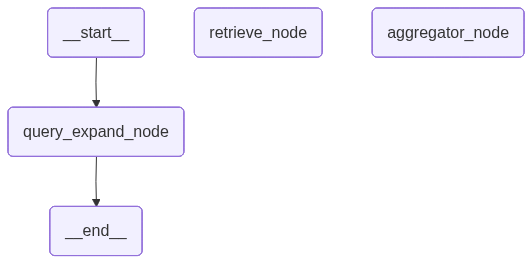

In [69]:
graph

In [67]:
initial_state = {
    "initial_query": "Can I get a tablet for my kid, a watch for me and a laptop for my wife?"
}
result = graph.invoke(initial_state)

In [68]:
print(result["answer"])

Yes, you can get a tablet for your kid, a watch for yourself, and a laptop bag for your wife from the available products. Here are some detailed options for each:

Tablet for Kids:
- ROWT Tablet for Kids 10 inch
  - 10.1 inch HD 1280x800 IPS touchscreen
  - Android 11 OS
  - 2GB RAM, 32GB ROM storage
  - 6000mAh battery
  - Kid-proof case with built-in stand
  - Parental controls with password protection, content filter, and one-button lock screen
  - Access to Google Play Store
  - Dual cameras
  - Blue color

Watch for You:
- Blackview R5 Fitness Activity Tracker Smartwatch
  - 24 sports modes
  - Heart rate monitor and blood oxygen SpO2
  - IP68 waterproof
  - Sleep tracking
  - Notifications for calls, SMS, and apps
  - Long battery life (9-15 days)
  - Compatible with iOS 9.0 and Android 4.3+
  - Orange color

Laptop Bag for Your Wife:
- Kuosdaz Travel Laptop Backpack
  - Fits laptops up to 15.6 inch
  - Water-resistant polyester fabric
  - USB charging port with built-in cable
  